In [1]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.summarization import keywords
from gensim.summarization import summarize

model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [ ]:
import pandas as pd

df = pd.read_csv("training_set_rel3.tsv", sep="\t", encoding="ISO-8859-1")
#df.head()

In [ ]:
#t = df[df["essay_set"]==8]["essay"]
i = 0
for x in t:
    if len(x)>5000:
        f = open("./test/t_"+str(i)+".txt", 'w')
        f.write(x)
        f.close()
        i+=1
print(i)

In [45]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from summarization import Summarizer

summarizer = Summarizer("sample4")
sums = summarizer.summarize_all()

files = summarizer.files 
print(files)

for sum in sums:
    print(sum, len(sum))



['04-Essay01', '04-Essay02', '04-Essay03', '04-Essay04']
['Mars has a striking red appearance, and in its most favorable position for viewing, when it is opposite the sun, it is twice as bright as Sirius, the brightest star.', 'The greater part of the surface area of Mars appears to be a vast desert, dull red or orange in color.', 'Photographs sent back by the Mariner 4 space probe show the surface of Mars to be pitted with a number of large craters, much like the surface of our moon.', 'Analysis of the satellite data indicates that Mars appears to lack active plate tectonics at present; there is no evidence of recent lateral motion of the surface.', 'The possible identification of rounded pebbles and cobbles on the ground, and sockets and pebbles in some rocks, suggests conglomerates that formed in running water during a warmer past some 2-4 billion years ago, when liquid water was stable and there was water on the surface, possibly even large lakes or oceans.', 'There is also evidenc

In [46]:
corpus = []
d = dict()

i = 0
for sum in sums:
    for x in sum:
        corpus.append(x)
        d[x] = i
        i+=1
        
len(corpus)

41

In [ ]:
# sentence_obama = 'Obama speaks to the media in Illinois'.lower().split()
# sentence_president = 'The president greets the press in Chicago'.lower().split()

# model.wmdistance(sentence_obama, sentence_president)

In [47]:
# corpus = [
#     "Can you be more specific with your question?",
#     "Are you able to eliminate ambiguity from your question?",
#     "Could you be more specific?",
#     "Can you explain yourself more clearly?",
#     "Please be more specific",
#     "Will you restate your question more clearly?",
#     "Quick brown fox jumped over the lazy dog",
#     "The dog lay on the floor and the fox jumped over it",
#     "Unlike the dog, the fox was quick and brown and was able to jump over the dog",
#     "The dog was lazy and could not reach the fox which jumped over it",
#     "The dog could not match the fox's speed who easily jumped over it and disappeared"
# ]

data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    #res = []
    res = 0
    n = 0
    for word in sentence:
        try:
            res+=model[word]
            #res.append(model[word])
            n+=1
        except:
            pass
    res/=n
    #print(n)
    #for i in range(50-n):
    #    res.append([0]*300)
    res = np.array(res)
    #print(res.shape)
    data.append(res.reshape(-1))
    
data = np.array(data)
#data

In [ ]:
[0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0]
[1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0]

As the train climbs into the Himalayan foothills the view opens up, revealing the plantations where the world famed Darjeeling tea is grown.


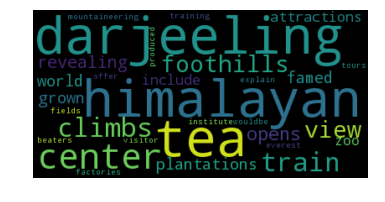

Mars has a striking red appearance, and in its most favorable position for viewing, when it is opposite the sun, it is twice as bright as Sirius, the brightest star.


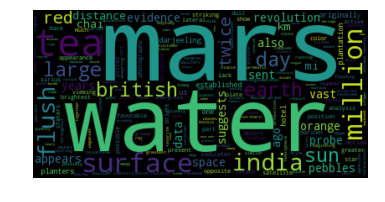

Although higher prices encourage consumers of oil to try to economize on its use, OPEC countries correctly forecast that cutbacks in the quantity demanded would be small since most other nations were very dependent on oil and had few commodities available as potential substitutes for oil.


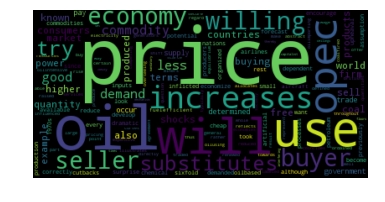

The notion of a "free market" where all economic decisions regarding transfers of money, goods, and services take place on a voluntary basis, free of coercive influence, is commonly considered to be an essential characteristic of capitalism.


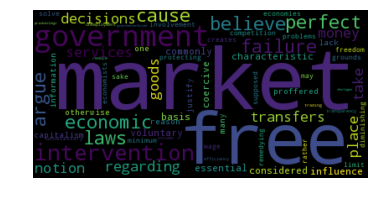

In [49]:
NUM_CLUSTERS = 4

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=25) #euclidean_distance #cosine_distance
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(assigned_clusters)

import re
from collections import Counter
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))
    cnt = Counter(text)
    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()
    
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    print(cluster[0])
    plt.show()

In [50]:
weights = [0.5,0.2,0.3, 1]

In [51]:
i = 0
for essay in sums:
    res = 0
    for sentance in essay:
        k = assigned_clusters[d[sentance]]
        #print(k)
        res+= weights[k]
    print(files[i], round(res,1))
    i+=1

04-Essay01 2.0
04-Essay02 2.9
04-Essay03 3.2
04-Essay04 6.5
